In [1]:
import pandas as pd
from datetime import datetime, date
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer, StandardScaler   
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data = pd.read_json('sherdog/data/cumulative2.json')

In [3]:
wins = len(data[data['result'] == 'win'])
print('Dummy accuracy is {:.2f}%'.format(wins/len(data)*100))

Dummy accuracy is 50.00%


In [4]:
sample = data
sample['isgsp'] = sample['fighter'].apply(lambda x: 'Georges-St-Pierre' in x['id'])
sample = sample[sample['isgsp'] == True]
sample.drop(['isgsp'], axis=1, inplace=True)
# sample.iloc[3].to_dict()

In [5]:
def get_method(x):
    if x:
        x = x.strip()
    else:
        x = ''
    methodsmap = {'': 'decision', '(draw)': 'decision', '(forfeit)': 'ko',
                  '(head kick and punches)': 'ko', '(illegal slam)': 'ko',
                  '(no contest)': 'decision', '83185': 'decision', '_____È': 'decision',
                  'armbar': 'submission', 'brabo choke': 'submission', 
                  'bulldog choke': 'submission', 'choke': 'submission', 'decision': 'decision', 
                  'decision unanimous)': 'decision', 'decisionn': 'decision', 
                  'decisions': 'decision', 'decison': 'decision', 'default': 'decision',
                  'disqualification': 'decision', 'dq': 'decision', 'draw': 'decision',
                  'ee stoppage from a cut)': 'ko','forfeit': 'ko','igor lumpov': 'submission',
                  'isaac yap': 'submission','k)': 'ko','knockout': 'ko','ko': 'ko','ko/tko': 'ko',
                  'ko/tko punches': 'ko','ko/tko, ground and pound': 'ko',
                  'majority draw': 'decision','mata leon': 'submission','method': 'decision',
                  'n/a': 'decision','nc': 'decision','no contest': 'decision',
                  'no contrst': 'decision','points': 'decision','retirement': 'decision',
                  'rich mitchell': 'decision','s': 'submission','split decision': 'decision',
                  'subimssion': 'submission','submision': 'submission','submisison': 'submission',
                  'submissio': 'submission','submissiom': 'submission','submission': 'submission',
                  'submission armbar': 'submission','submission rear naked choke': 'submission',
                  'submission verbal tap out': 'submission','submission(triangle choke)': 'submission',
                  'submission-guillotine choke': 'submission','submisson': 'submission',
                  'submssion': 'submission','tapout': 'submission','techincal submission': 'submission',
                  'technial submission': 'submission','technical decision': 'decision',
                  'technical submission': 'submission','technical sumbission': 'submission',
                  'tko': 'ko','tko(punches)': 'ko','tko(strikes)': 'ko','tko/medical stoppage': 'ko',
                  'towel': 'ko','ubmission': 'submission','unanimous decision': 'decision',
                  'verbal submission': 'submission','walkover': 'decision','yko': 'ko'}
    return methodsmap[x]
    
    

def parse_date(timeinmilis):
    try:
        timestamp = timeinmilis / 1000
        res = datetime.utcfromtimestamp(timestamp)
        return res
    except:
        return date(2000, 1, 1)
    

def clean_last_fight(x):
    if x <= 0.0:
        return 0.0
    else:
        return x

    
def get_label(event_timestamp):
    event_date = event_timestamp.date()
    if event_date >= date(2015, 1, 1):
        return 'test'
    else:
        return 'train'

    
def flatten(data, detailed=False):
    X = pd.DataFrame()
    if detailed:
        X['target'] = data['method'].apply(get_method)
        X['target'] = X['target'] + data['result']
    else:
        X['target'] = data['result'].map({'win': 1, 'loss': 0})
    for fighter in ['fighter', 'opponent']:
        for key in ['started']:
            curr = '{}_{}'.format(fighter, key)
            first_fight_date = data[fighter].apply(lambda x: parse_date(x[key]))
            event_date = data['date']
            X[curr] = event_date - first_fight_date
            X[curr] = X[curr].apply(lambda x: clean_last_fight(x.days))
            
            
        for key in ['since_last_fight']:
            curr = '{}_{}'.format(fighter, key)
            X[curr] = data[fighter].apply(lambda x: x[key])

        # Cumulative stats
        stats = 'cumulative'
        for key in ['loss', 'win']:
            for result in ['loss', 'win']:
                for method in ['decision', 'knockout', 'submission', 'total']:
                    curr = '{}_{}_{}_{}_{}'.format(fighter, stats, key, result, method)
                    X[curr] = data[fighter].apply(lambda x: x[stats][key][result][method])
                    X[curr] = X[curr].apply(lambda x: float(x))

        # Historical stats
        stats = 'history'
        for result in ['loss', 'win']:
            for method in ['decision', 'knockout', 'submission', 'total']:
                curr = '{}_{}_{}_{}'.format(fighter, stats, result, method)
                X[curr] = data[fighter].apply(lambda x: x[stats][result][method])
                X[curr] = X[curr].apply(lambda x: float(x))
        
        # Streak
        stats = 'streak'
        for result in ['loss', 'win']:
            curr = '{}_{}_{}'.format(fighter, stats, result)
            X[curr] = data[fighter].apply(lambda x: x[stats][result])
            X[curr] = X[curr].apply(lambda x: float(x))
        
        stats = 'history'
        for key in ['fights', 'positions', 'time']:
            curr = '{}_{}_{}'.format(fighter, stats, key)
            X[curr] = data[fighter].apply(lambda x: x[stats][key])
            X[curr] = X[curr].apply(lambda x: float(x))
    
    return X


def get_data(data, detailed=False, scaled=False):
    data['set'] = data['date'].apply(get_label)
    train = data[data['set'] == 'train']
    test = data[data['set'] == 'test']
    
    X_train = flatten(train, detailed)
    y_train = X_train['target']
    X_train.drop(['target'], axis=1, inplace=True)
    X_train.fillna(0, inplace=True)
        
    
    X_test = flatten(test, detailed)
    y_test = X_test['target']
    X_test.drop(['target'], axis=1, inplace=True)
    X_test.fillna(0, inplace=True)
    
    if scaled:
        # Scale data
        scaler = StandardScaler()
        scaler.fit(X_train)

        X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    
    print('{:.2f}% ({}) of fights in the training dataset'.format(
        len(train)/len(data)*100, len(train)))
    print('{:.2f}% ({}) of fights in the testing dataset'.format(
        len(test)/len(data)*100, len(test)))
    
    return X_train, X_test, y_train, y_test, train, test

In [6]:
X_train, X_test, y_train, y_test, train, test = get_data(data, scaled=True)

78.39% (335978) of fights in the training dataset
21.61% (92636) of fights in the testing dataset


In [7]:
model = LogisticRegression()
model.fit(X_train, y_train)

print('LogisticRegression training {:.2f}%'.format(
    accuracy_score(y_train, model.predict(X_train))*100))
print('LogisticRegression testing {:.2f}%'.format(
    accuracy_score(y_test, model.predict(X_test))*100))
feats = {feature: importance for feature, importance in zip(X_train.columns, model.coef_[0])}
importances = pd.DataFrame.from_dict(feats, orient='index')
importances = importances.rename(columns={0: 'Importance', 1: 'Feature'})
importances = importances.iloc[importances['Importance'].abs().argsort()].iloc[::-1]
importances.head(5)

LogisticRegression training 68.38%
LogisticRegression testing 67.21%


,Importance
fighter_cumulative_loss_win_submission,0.459607
opponent_cumulative_loss_win_submission,-0.459605
fighter_cumulative_win_win_submission,-0.326874
opponent_cumulative_win_win_submission,0.326872
fighter_cumulative_loss_win_total,0.318407


In [8]:
# model = SVC()
# model.fit(X_train, y_train)

# print('SVC training {:.2f}%'.format(
#     accuracy_score(y_train, model.predict(X_train))*100))
# print('SVC testing {:.2f}%'.format(
#     accuracy_score(y_test, model.predict(X_test))*100))

In [23]:
model = RandomForestClassifier(min_samples_split=150, random_state=42)
model.fit(X_train, y_train)

print('RandomForestClassifier training {:.2f}%'.format(
    accuracy_score(y_train, model.predict(X_train))*100))
print('RandomForestClassifier testing {:.2f}%'.format(
    accuracy_score(y_test, model.predict(X_test))*100))
feats = {feature: importance for feature, importance in zip(X_train.columns, model.feature_importances_)}
importances = pd.DataFrame.from_dict(feats, orient='index')
importances = importances.rename(columns={0: 'Importance', 1: 'Feature'})
importances = importances.iloc[importances['Importance'].abs().argsort()].iloc[::-1]
importances.head(5)

RandomForestClassifier training 78.00%
RandomForestClassifier testing 76.39%


,Importance
fighter_cumulative_win_win_total,0.075181
opponent_cumulative_win_win_total,0.073054
fighter_history_win_total,0.050851
opponent_cumulative_win_win_decision,0.042877
opponent_history_win_total,0.034030


In [24]:
input_dim = X_train.shape[1]
model = Sequential()
model.add(Dense(512, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
batch_size = 8192
adamhist = model.fit(X_train.values, y_train, epochs=250, batch_size=batch_size, validation_split=0.2)

Train on 268782 samples, validate on 67196 samples
Epoch 1/250
268782/268782 [==============================] - 3s - loss: 0.6315 - acc: 0.6415 - val_loss: 0.5922 - val_acc: 0.6858

In [25]:
scores = model.evaluate(X_test.values, y_test, batch_size=batch_size)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

90112/92636 [============================>.] - ETA: 0s
acc: 80.08%


In [37]:
input_dim = X_train.shape[1]
model = Sequential()
model.add(Dense(512, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
batch_size = 8192
sgdhist = model.fit(X_train.values, y_train, epochs=250, batch_size=batch_size, validation_split=0.2)

Train on 268782 samples, validate on 67196 samples
Epoch 1/250
268782/268782 [==============================] - 1s - loss: 0.7090 - acc: 0.5106 - val_loss: 0.6930 - val_acc: 0.5416

In [38]:
scores = model.evaluate(X_test.values, y_test, batch_size=batch_size)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

90112/92636 [============================>.] - ETA: 0s
acc: 68.26%


In [39]:
input_dim = X_train.shape[1]
model = Sequential()
model.add(Dense(512, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
batch_size = 8192
rmshist = model.fit(X_train.values, y_train, epochs=250, batch_size=batch_size, validation_split=0.2)

Train on 268782 samples, validate on 67196 samples
Epoch 1/250
268782/268782 [==============================] - 1s - loss: 0.6415 - acc: 0.6383 - val_loss: 0.5963 - val_acc: 0.6830

In [40]:
scores = model.evaluate(X_test.values, y_test, batch_size=batch_size)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

90112/92636 [============================>.] - ETA: 0s
acc: 78.57%


In [22]:
test['predictions'] = model.predict(X_test.values)
test['fighterid'] = test['fighter'].apply(lambda x: x['id'])
test['opponentid'] = test['opponent'].apply(lambda x: x['id'])
results = test.drop(['fighter', 'opponent', 'set', 'id', 'location', 'details'], axis=1)
results.to_csv('results.csv', index=False)

In [14]:
def show_organization_stats():
    for organization in ['Ultimate Fighting Championship', 
                         'Bellator MMA',
                         'Jungle Fight',
                         'Konfrontacja Sztuk Walki',
                         'Absolute Championship Berkut']:
        subset = results[results['organization'] == organization]
        score = accuracy_score(subset['result'].map({'win': 1, 'loss': 0}), subset['predictions'].apply(lambda x: round(x)))
        print('{} accuracy score: {:.2f}%'.format(organization, score*100))

In [15]:
def show_yearly_stats():
    results['year'] = results['date'].apply(lambda x: x.year)
    for year in sorted(results['year'].unique().tolist()):
        subset = results[results['year'] == year]
        score = accuracy_score(subset['result'].map({'win': 1, 'loss': 0}),
                               subset['predictions'].apply(lambda x: round(x)))
        print('{} accuracy score: {:.2f}%'.format(year, score*100))

In [23]:
ids = test['id'].unique()
fights = test.T.to_dict().values()
pairs = {}

for fight in fights:
    idx = fight['id']
    if idx in pairs:
        pairs[idx].append(fight)
    else:
        pairs[idx] = [fight]

In [24]:
results = []
for key, pair in pairs.items():
    fighter = pair[0]
    opponent = pair[1]
    current = {'prediction': 0, 'result': 0}
    if fighter['predictions'] > opponent['predictions']:
        current['prediction'] = 1
    else:
        current['prediction'] = 0
        
    if fighter['result'] == 'win':
        current['result'] = 1
    else:
        current['result'] = 0
    
    results.append(current)

results = pd.DataFrame(results)

In [25]:
score = accuracy_score(results['result'], results['prediction'])
print('Accuracy score for actuall predictions: {:.2f}%'.format(score*100))

Accuracy score for actuall predictions: 79.42%


In [36]:
X_train_multi, X_test_multi, y_train_multi, y_test_multi, train_multi, test_multi = get_data(data, 
                                                                                             detailed=True, 
                                                                                             scaled=True)

78.39% (335978) of fights in the training dataset
21.61% (92636) of fights in the testing dataset


In [37]:
import numpy as np
mapping = {'kowin': 1, 'koloss': 2, 
           'decisionwin': 3, 'decisionloss': 4,
           'submissionloss': 5, 'submissionwin': 6}
y_train_multi = y_train_multi.map(mapping)
y_test_multi = y_test_multi.map(mapping)
counts = np.bincount(y_test_multi)
most_frequent_result = np.argmax(counts)
most_frequent = None
for key, value in mapping.items():
    if value == most_frequent_result:
        most_frequent = key
most_frequents = len(data[data['result'] == most_frequent_result])
print('Dummy accuracy is {:.2f}%'.format(max(counts)/len(y_test)*100))
print('Most frequent result is {}'.format(most_frequent))

y_train_multi = to_categorical(y_train_multi)
y_test_multi = to_categorical(y_test_multi)

Dummy accuracy is 18.33%
Most frequent result is kowin


In [38]:
input_dim = X_train_multi.shape[1]
model_multi = Sequential()
model_multi.add(Dense(1024, input_dim=input_dim, activation='relu'))
model_multi.add(Dropout(0.5))
model_multi.add(Dense(512, activation='relu'))
model_multi.add(Dropout(0.5))
model_multi.add(Dense(256, activation='relu'))
model_multi.add(Dropout(0.5))
model_multi.add(Dense(128, activation='relu'))
model_multi.add(Dropout(0.5))
model_multi.add(Dense(7, activation='sigmoid'))
model_multi.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:
batch_size = 32768
model_multi.fit(X_train_multi.values, y_train_multi, epochs=100, batch_size=batch_size, validation_split=0.2)

Train on 268782 samples, validate on 67196 samples
Epoch 1/100
268782/268782 [==============================] - 3s - loss: 1.8529 - acc: 0.1918 - val_loss: 1.7634 - val_acc: 0.2152
Epoch 2/100
268782/268782 [==============================] - 2s - loss: 1.7836 - acc: 0.2151 - val_loss: 1.7664 - val_acc: 0.2668

In [41]:
scores = model_multi.evaluate(X_test_multi.values, y_test_multi, batch_size=batch_size)
print("\n%s: %.2f%%" % (model_multi.metrics_names[1], scores[1]*100))

92636/92636 [==============================] - 0s     

acc: 57.67%


In [52]:
import pandas as pd
frame = pd.read_csv('sherdog/data/merged.csv')
frame.iloc[0].to_dict()

{'date': '04.11.2017',
 'details': 'punches and elbows',
 'fighter': '/fighter/Michail-Tsarev-20368',
 'fighter association': 'Alexander Nevsky Club',
 'fighter birth': '22.06.1986',
 'fighter height': '05.lis',
 'fighter nationality': 'Russia',
 'location': 'Lada Arena / Tolyatti / Samara / Russia',
 'method': 'tko',
 'opponent': '/fighter/Artur-Guseinov-14783',
 'opponent association': 'AP Promotion',
 'opponent birth': '14.05.1984',
 'opponent height': '05.sty',
 'opponent nationality': 'Russia',
 'organization': 'Fight Nights Global',
 'position': 1,
 'result': 'win',
 'rounds': 1,
 'time': '4.433333333333334',
 'title': 'FNG, Fight Nights Global 78'}

In [68]:
sample = frame
sample['isgsp'] = sample['fighter'].apply(lambda x: 'Georges-St-Pierre' in x)
sample = sample[sample['isgsp'] == True]
sample.drop(['isgsp'], axis=1, inplace=True)

In [73]:
sample.iloc[5].to_dict()

{'date': '31.01.2009',
 'details': 'corner stoppage',
 'fighter': '/fighter/Georges-St-Pierre-3500',
 'fighter association': 'Tristar Gym',
 'fighter birth': '19.05.1981',
 'fighter height': '05.sty',
 'fighter nationality': 'Canada',
 'location': 'MGM Grand Garden Arena / Las Vegas / Nevada / United States',
 'method': 'tko',
 'opponent': '/fighter/BJ-Penn-1307',
 'opponent association': "BJ Penn's MMA",
 'opponent birth': '13.12.1978',
 'opponent height': '05.wrz',
 'opponent nationality': 'United States',
 'organization': 'Ultimate Fighting Championship',
 'position': 1,
 'result': 'win',
 'rounds': 4,
 'time': '5.0',
 'title': 'UFC 94, St. Pierre vs. Penn 2'}

In [48]:
print(plt.style.available)

['grayscale', 'ggplot', 'seaborn-poster', 'seaborn-notebook', 'seaborn-deep', 'seaborn-muted', 'bmh', 'classic', 'seaborn-dark-palette', 'seaborn-pastel', 'fivethirtyeight', 'seaborn-talk', 'seaborn-bright', 'seaborn-paper', 'seaborn-ticks', 'seaborn-whitegrid', 'dark_background', 'seaborn-darkgrid', 'seaborn', 'seaborn-dark', 'seaborn-white', 'seaborn-colorblind']


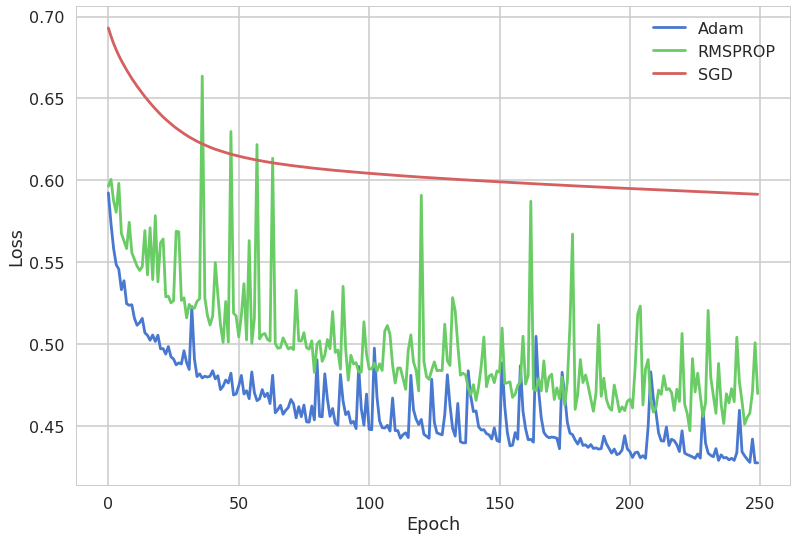

In [71]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-muted')
plt.plot(adamhist.history['val_loss'])
plt.plot(rmshist.history['val_loss'])
plt.plot(sgdhist.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Adam', 'RMSPROP', 'SGD'], loc='upper right')
plt.show()